<a href="https://colab.research.google.com/github/abm4github/cardiovascular-risk-prediction_Supervised-Classification/blob/main/AlmaBetter_ML_Classification_CardioVascularRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

In [2]:
# mount drive and give path of dataset
data = pd.read_csv("/content/drive/MyDrive/AlmaBetter ML Classification Deliverables/data_cardiovascular_risk.csv")

In [3]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
757,757,55,1.0,M,NO,0.0,0.0,0,0,0,237.0,124.0,84.0,28.18,63.0,97.0,0
1081,1081,57,1.0,M,YES,20.0,0.0,0,0,0,198.0,128.0,85.0,28.18,85.0,99.0,0
3299,3299,50,1.0,F,YES,9.0,0.0,0,0,0,229.0,114.0,68.0,23.20,90.0,70.0,0
2601,2601,43,4.0,M,YES,20.0,0.0,0,0,0,171.0,110.0,74.5,25.09,70.0,85.0,0
340,340,43,2.0,M,YES,20.0,0.0,0,1,0,243.0,155.0,100.0,24.89,80.0,63.0,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [5]:
data.isna().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

##Dealing with null values

Note: This part is postponed for later stages, now proceeding with deletion of null values.

Missing values in variable "glucose" are 304 in count, deleting them may cause loss of data, so checking correlation between "glucose" and "TenYearCHD"

In [6]:
# glucose_TenYearCHD_data = data[['glucose','TenYearCHD']]
# correlation_1 = glucose_TenYearCHD_data.corr(method = 'pearson')
# print(correlation_1)

In [7]:
# data['glucose'].describe()

Deleting rows with Null Values

In [8]:
data.dropna(inplace=True)

Re-checking null values, if any and new shape of data

In [9]:
data.isna().sum().sum()

0

In [10]:
data.shape

(2927, 17)

##Dropping irrelavant variables and duplicates if any.

In [11]:
data.columns

Index(['id', 'age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [12]:
data.drop("id", axis=1, inplace=True)
data.drop_duplicates(inplace=True)

In [13]:
data.shape

(2927, 16)

here shape confirms that there are no duplicates and total columns reduced to 16

In [14]:
data.describe()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000,2927.000000
mean,49.507345,1.965494,9.112743,0.030065,0.006150,0.314315,0.026990,237.129142,132.626409,82.906218,25.797041,75.888282,81.934404,0.151691
std,8.597191,1.017199,11.882784,0.170795,0.078192,0.464322,0.162082,44.613282,22.326197,12.078873,4.130376,11.971207,24.106943,0.358783
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,113.000000,83.500000,48.000000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.500000,23.030000,68.000000,71.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.500000,82.000000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.000000,28.040000,83.000000,87.000000,0.000000
max,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,600.000000,295.000000,142.500000,56.800000,143.000000,394.000000,1.000000


## Exploratory Data Analysis

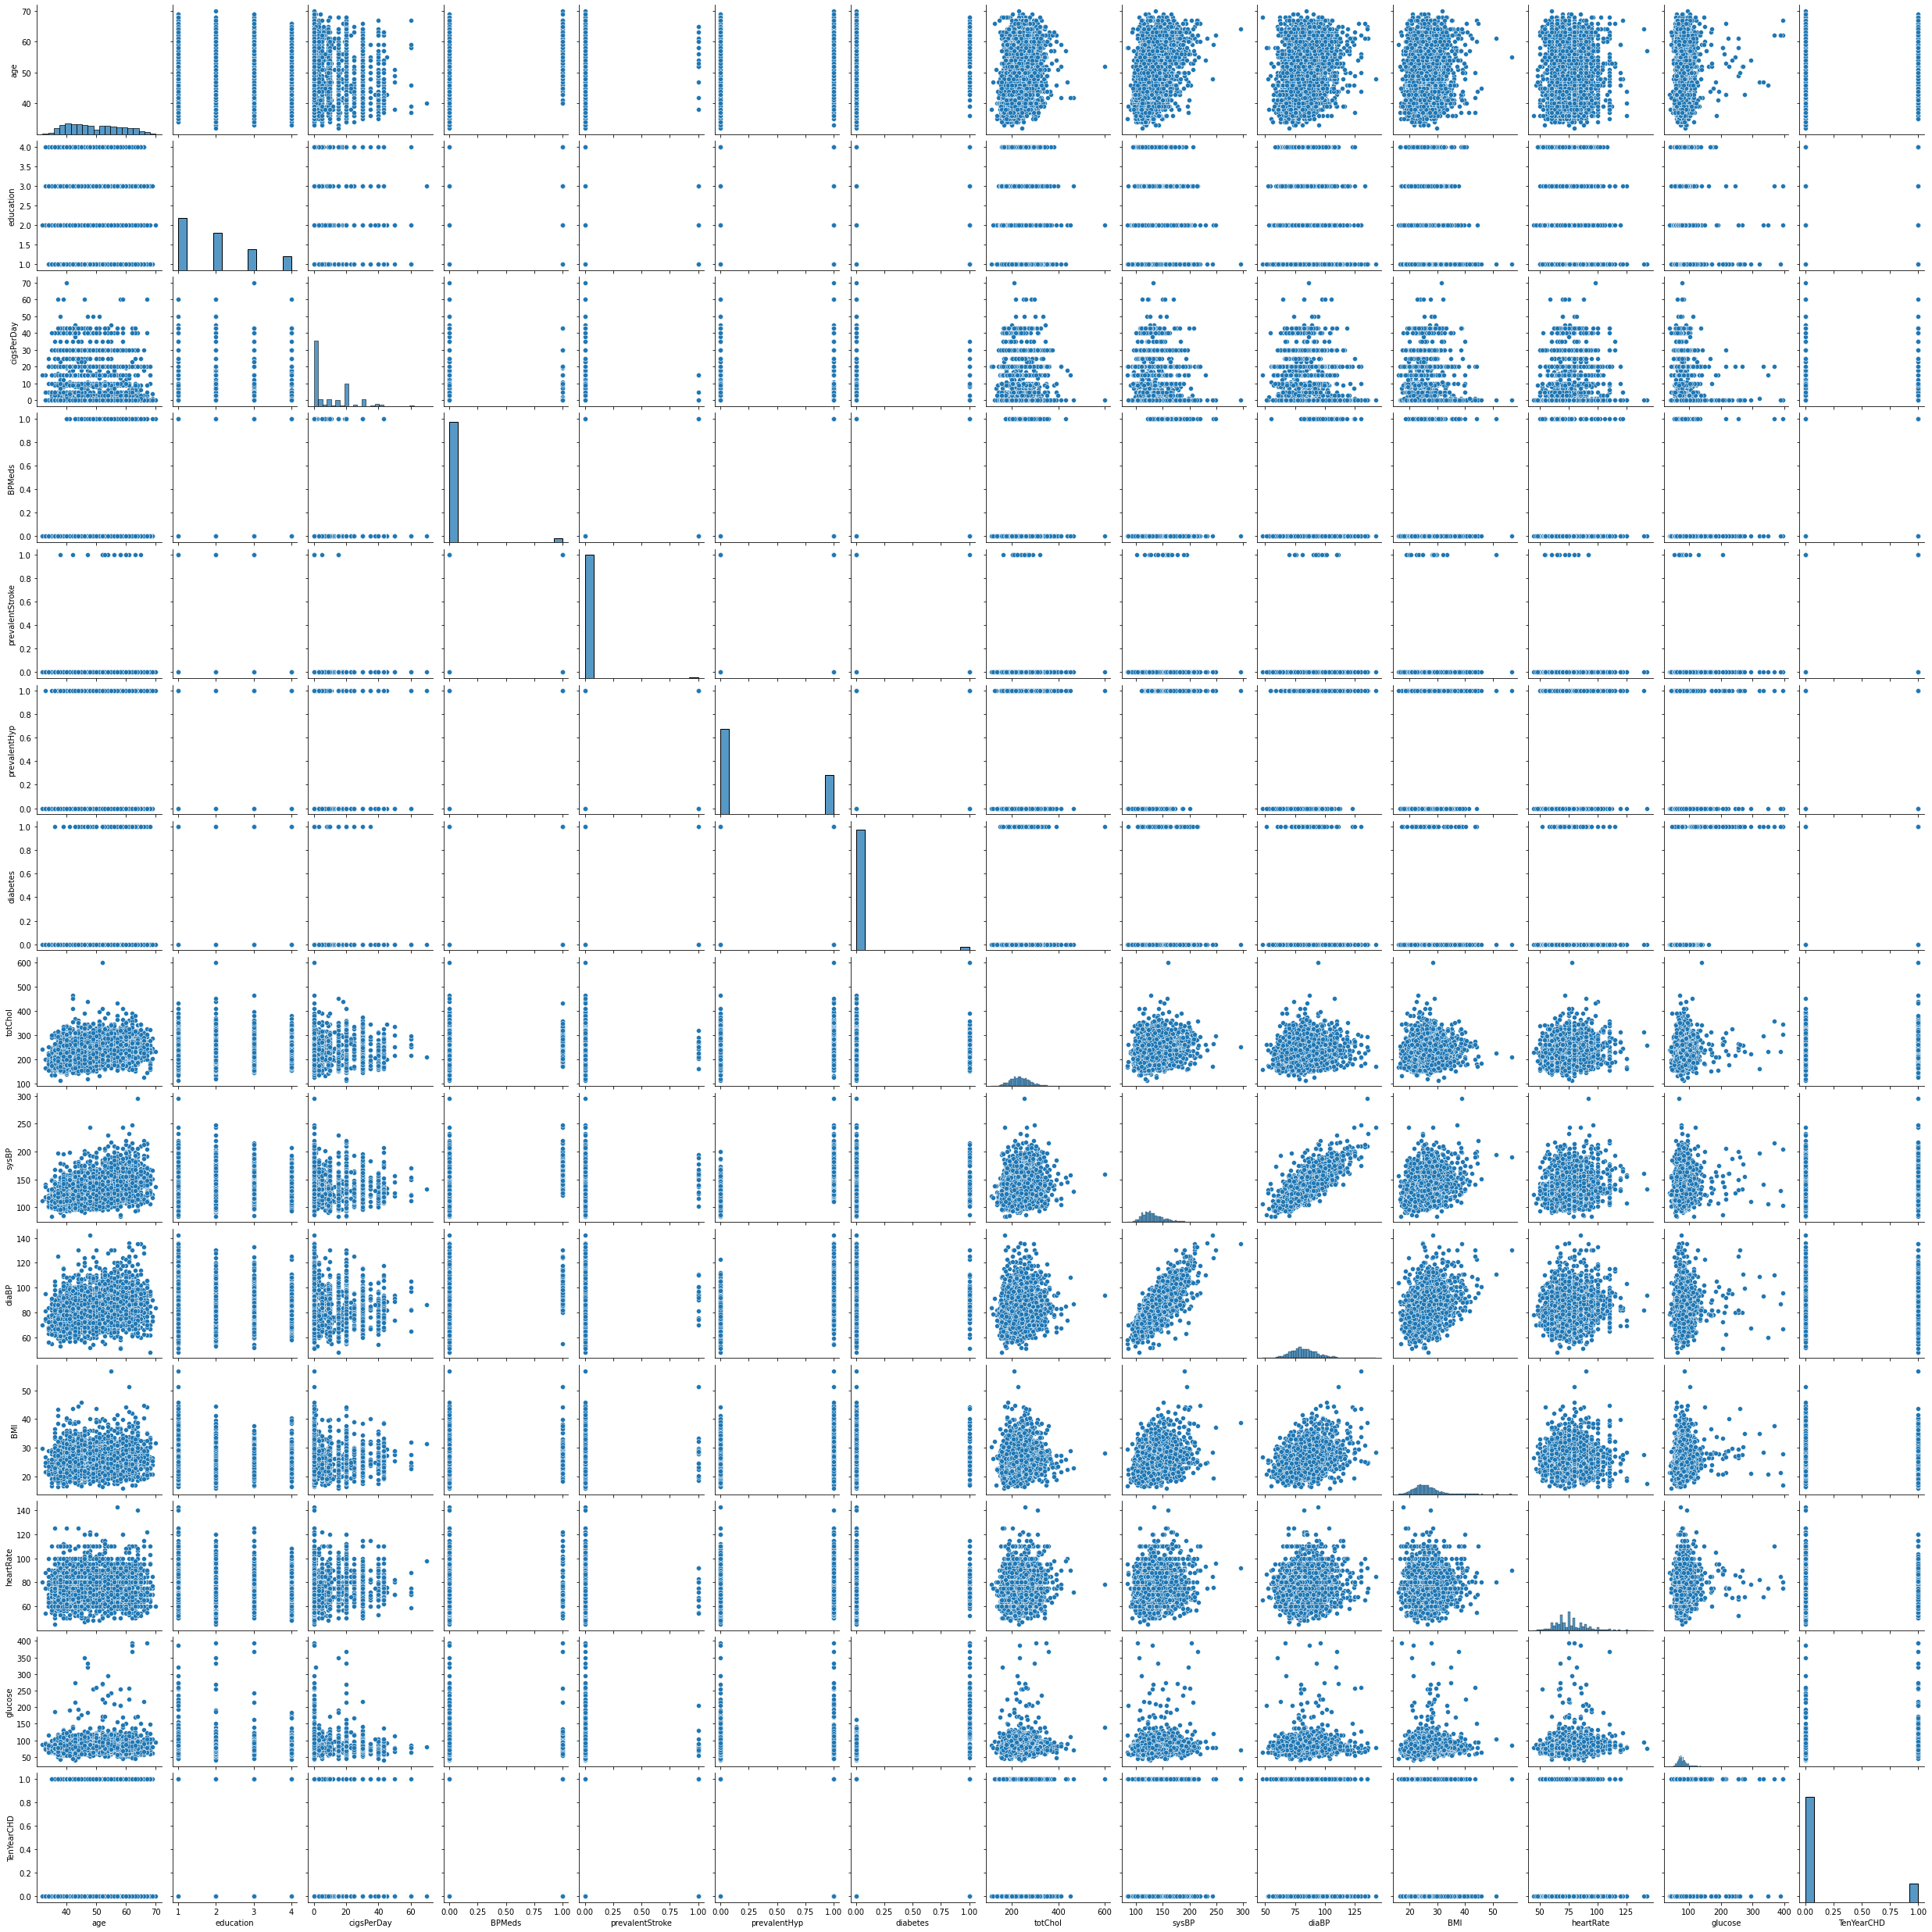

In [15]:
sns.pairplot(data)

##Dealing with object type variables 

In [16]:
data['education'].unique()

array([4., 1., 3., 2.])

In [17]:
data['sex'].unique()

array(['M', 'F'], dtype=object)

In [18]:
data['is_smoking'].unique()

array(['NO', 'YES'], dtype=object)

In [19]:
data = pd.get_dummies(data, drop_first=True)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 1 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              2927 non-null   int64  
 1   education        2927 non-null   float64
 2   cigsPerDay       2927 non-null   float64
 3   BPMeds           2927 non-null   float64
 4   prevalentStroke  2927 non-null   int64  
 5   prevalentHyp     2927 non-null   int64  
 6   diabetes         2927 non-null   int64  
 7   totChol          2927 non-null   float64
 8   sysBP            2927 non-null   float64
 9   diaBP            2927 non-null   float64
 10  BMI              2927 non-null   float64
 11  heartRate        2927 non-null   float64
 12  glucose          2927 non-null   float64
 13  TenYearCHD       2927 non-null   int64  
 14  sex_M            2927 non-null   uint8  
 15  is_smoking_YES   2927 non-null   uint8  
dtypes: float64(9), int64(5), uint8(2)
memory usage: 348.7 KB


In [21]:
corr = data.corr()
corr[-3:]

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,sex_M,is_smoking_YES
TenYearCHD,0.234423,-0.062442,0.059797,0.092868,0.052014,0.169136,0.100006,0.106473,0.217419,0.139005,0.075950,0.018747,0.133286,1.000000,0.081880,0.033342
sex_M,-0.034307,0.033854,0.347277,-0.041431,-0.009121,-0.001199,0.007311,-0.074135,-0.046803,0.052869,0.073776,-0.120345,-0.011242,0.081880,1.000000,0.223871
is_smoking_YES,-0.204398,0.030861,0.775714,-0.042033,-0.051558,-0.123369,-0.050831,-0.047703,-0.148528,-0.131062,-0.165179,0.053532,-0.058830,0.033342,0.223871,1.000000


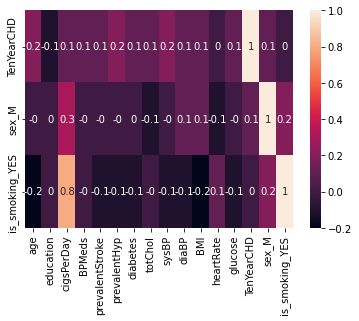

In [22]:
sns.heatmap(round(corr[-3:], 1), annot=True)

our data is now free of object type data

## Data prepation to modeling

In [23]:
data.sample(5)

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,sex_M,is_smoking_YES
277,42,2.0,9.0,0.0,0,0,0,205.0,110.0,73.0,22.40,61.0,66.0,0,1,1
3125,53,3.0,43.0,0.0,0,0,0,238.0,126.0,72.0,23.40,62.0,73.0,0,1,1
3310,65,4.0,1.0,0.0,0,1,0,322.0,165.0,95.0,22.84,80.0,81.0,0,0,1
1939,45,1.0,5.0,0.0,0,1,0,268.0,130.0,94.0,34.27,85.0,93.0,0,0,1
463,56,1.0,0.0,0.0,0,1,0,206.0,140.0,87.0,27.72,60.0,85.0,0,0,0


Splitting target variable from independent variables

In [24]:
target_variable = 'TenYearCHD'
X = data.drop([target_variable], axis=1).values
y = data[target_variable].values

In [25]:
X

array([[36.,  4.,  0., ..., 75.,  1.,  0.],
       [46.,  1., 10., ..., 94.,  0.,  1.],
       [50.,  1., 20., ..., 94.,  1.,  1.],
       ...,
       [46.,  1.,  0., ..., 84.,  0.,  0.],
       [44.,  3.,  3., ..., 72.,  1.,  1.],
       [54.,  3.,  0., ..., 92.,  0.,  0.]])

In [26]:
y

array([0, 0, 1, ..., 0, 1, 0])

Splitting train and test data

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [28]:
X_train

array([[53.,  2., 20., ..., 80.,  0.,  1.],
       [53.,  1.,  0., ..., 77.,  0.,  0.],
       [57.,  1., 20., ..., 83.,  1.,  1.],
       ...,
       [46.,  2., 15., ..., 86.,  0.,  1.],
       [68.,  1.,  0., ..., 79.,  1.,  0.],
       [39.,  3.,  0., ..., 88.,  0.,  0.]])

In [29]:
y_train

array([0, 0, 1, ..., 0, 1, 0])

In [30]:
X_test

array([[65.,  1.,  3., ..., 78.,  0.,  1.],
       [56.,  2.,  5., ..., 85.,  0.,  1.],
       [56.,  3.,  0., ..., 75.,  0.,  0.],
       ...,
       [42.,  1.,  0., ..., 96.,  0.,  0.],
       [64.,  4.,  9., ..., 62.,  0.,  1.],
       [50.,  2.,  0., ..., 90.,  0.,  0.]])

In [31]:
y_test

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

Feature Scaling X_train and X_test

In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [33]:
X_train_scaled

array([[ 0.41690903,  0.03194675,  0.92066157, ..., -0.06742334,
        -0.89563134,  1.01246556],
       [ 0.41690903, -0.95209728, -0.76255037, ..., -0.20396143,
        -0.89563134, -0.98768792],
       [ 0.88061448, -0.95209728,  0.92066157, ...,  0.06911475,
         1.11653082,  1.01246556],
       ...,
       [-0.3945755 ,  0.03194675,  0.49985858, ...,  0.20565285,
        -0.89563134,  1.01246556],
       [ 2.15580445, -0.95209728, -0.76255037, ..., -0.11293604,
         1.11653082, -0.98768792],
       [-1.20606003,  1.01599078, -0.76255037, ...,  0.29667824,
        -0.89563134, -0.98768792]])

In [34]:
X_test_scaled

array([[ 1.80802537, -0.95209728, -0.51006858, ..., -0.15844873,
        -0.89563134,  1.01246556],
       [ 0.76468811,  0.03194675, -0.34174739, ...,  0.16014015,
        -0.89563134,  1.01246556],
       [ 0.76468811,  1.01599078, -0.76255037, ..., -0.29498683,
        -0.89563134, -0.98768792],
       ...,
       [-0.85828095, -0.95209728, -0.76255037, ...,  0.66077982,
        -0.89563134, -0.98768792],
       [ 1.69209901,  2.00003481, -0.005105  , ..., -0.88665189,
        -0.89563134,  1.01246556],
       [ 0.06912994,  0.03194675, -0.76255037, ...,  0.38770364,
        -0.89563134, -0.98768792]])

Here is a data ready to be trained and tested, using any machine learning classification algorithm. 

## Decision Tree Classification

Training the Decision Tree Classification model on the Training set

In [63]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

Making the Confusion matrix

In [64]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(420, 72, 64, 30)

Calculating accuracy score

In [65]:
accuracy_score_DecisionTree = accuracy_score(y_test, y_pred)
print(accuracy_score_DecisionTree)

0.7679180887372014


##K-Nearest Neighbors (K-NN)

Training the K-NN model on the Training set

In [66]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Making the Confusion Matrix

In [67]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(473, 19, 87, 7)

Calculating accuracy score

In [68]:
accuracy_score_KNNClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_KNNClassifier)

0.8191126279863481


##Kernel SVM

Training the Kernel SVM model on the Training set

In [69]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train_scaled, y_train)

SVC(random_state=0)

Making the Confusion Matrix

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(491, 1, 94, 0)

Calculating accuracy score

In [71]:
accuracy_score_KernalSVM = accuracy_score(y_test, y_pred)
print(accuracy_score_KernalSVM)

0.8378839590443686


##Logistic Regression

Training the Logistic Regression model on the Training set

In [72]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train_scaled, y_train)

LogisticRegression(random_state=0)

Making the Confusion Matrix

In [73]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(485, 7, 87, 7)

Calculating accuracy score

In [74]:
accuracy_score_LogisticRegression = accuracy_score(y_test, y_pred)
print(accuracy_score_LogisticRegression)

0.8395904436860068


##Naive Bayes

Training the Naive Bayes model on the Training set

In [75]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train_scaled, y_train)

GaussianNB()

Making the Confusion Matrix

In [76]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(452, 40, 72, 22)

Calculating accuracy score

In [77]:
accuracy_score_NaiveBayes = accuracy_score(y_test, y_pred)
print(accuracy_score_NaiveBayes)

0.8088737201365188


##Random Forest Classification

Training the Random Forest Classification model on the Training set

In [78]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0)

Making the Confusion Matrix

In [79]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(477, 15, 91, 3)

Calculating accuracy score

In [80]:
accuracy_score_RandomForest = accuracy_score(y_test, y_pred)
print(accuracy_score_RandomForest)

0.8191126279863481


##Support Vector Machine (SVM)

Training the SVM model on the Training set

In [81]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=0)

Making the Confusion Matrix

In [82]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp
accuracy_score(y_test, y_pred)

0.8395904436860068

Calculating accuracy score

In [83]:
accuracy_score_SVM = accuracy_score(y_test, y_pred)
print(accuracy_score_SVM)

0.8395904436860068


##XGB Classifier

Training the SVM model on the Training set

In [84]:
from xgboost import XGBClassifier
classifier = XGBClassifier(random_state=0)
classifier.fit(X_train_scaled, y_train)

XGBClassifier()

Making the Confusion Matrix

In [85]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tn, fp, fn, tp

(484, 8, 90, 4)

Calculating accuracy score

In [86]:
accuracy_score_XGBClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_XGBClassifier)

0.8327645051194539


##Accuracy Scores of each classification model are as follows 

In [91]:
print(f'''Accuracy Scores:

Decision Tree Classification: {accuracy_score_DecisionTree}
K Nearest Neigbours         : {accuracy_score_KNNClassifier}
Kernal SVM                  : {accuracy_score_KernalSVM}
Logistic Regression         : {accuracy_score_LogisticRegression}
Naive Bayes                 : {accuracy_score_NaiveBayes}
Random Forest Classification: {accuracy_score_RandomForest}
Support Vector Machine      : {accuracy_score_SVM}
XGB Classifier              : {accuracy_score_XGBClassifier}
''')

Accuracy Scores:

Decision Tree Classification: 0.7679180887372014
K Nearest Neigbours         : 0.8191126279863481
Kernal SVM                  : 0.8378839590443686
Logistic Regression         : 0.8395904436860068
Naive Bayes                 : 0.8088737201365188
Random Forest Classification: 0.8191126279863481
Support Vector Machine      : 0.8395904436860068
XGB Classifier              : 0.8327645051194539

